In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from preprocessing import *

In [2]:
X = pd.read_csv('Data\X_train.csv')
y = pd.read_csv('Data\y_train.csv')
X_test = pd.read_csv('Data\X_test.csv')

X.head()
y.head()

,id,y
0,0.0,74.0
1,1.0,51.0
2,2.0,70.0
3,3.0,52.0
4,4.0,85.0


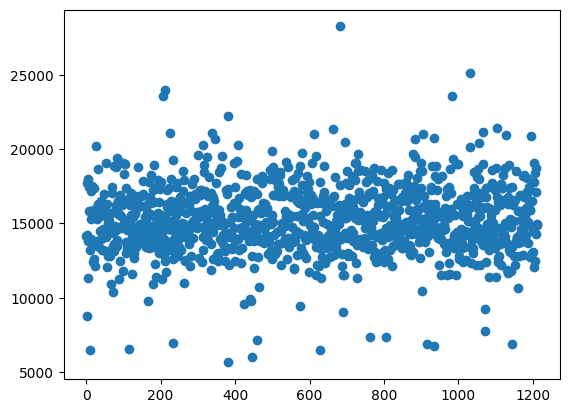

In [15]:
plt.scatter(X['id'],X['x0'])

In [16]:
print(len(X['id']))

1212


In [3]:
X.drop('id', axis=1, inplace=True)

X_train_no_NaN = replace_NaN(X, 5)

# Compare two dataframes element-wise
comparison = X == X_train_no_NaN

# Count the number of elements that are exactly the same
num_same_elements = comparison.sum().sum()

total_nan = X.isna().sum().sum()

total_vals = X.shape[0] * X.shape[1]

print(f"Total NaN values in the DataFrame: {total_nan}")
print(f"Number of elements that are exactly the same: {num_same_elements}")
print(f"Total number of values in the DataFrame: {total_vals}")


ValueError: Unable to coerce to Series, length must be 832: given 2

In [18]:
X = X_train_no_NaN

In [3]:
X.drop('id', axis=1, inplace=True)
y.drop('id', axis=1, inplace=True)

X = X.to_numpy()
y = y.to_numpy().ravel()

In [4]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the hyperparameter grid
alpha_values = [1, 5, 10]
n_neighbors_values = [3, 5, 7]
n_clusters_values = [2, 3, 4, 5]

poly = PolynomialFeatures(degree=2)
# Track the best score and corresponding hyperparameters
best_score = -np.inf
best_params = {}

accuracies = []

i = 0

for alpha in alpha_values:
    for n_neighbors in n_neighbors_values:
        for n_clusters in n_clusters_values:
            accuracies = []
            
            # Perform cross-validation for each combination of hyperparameters
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                
                

                # Step 1: Imputation (use n_neighbors as hyperparameter for KNNImputer)
                X_train_imputed, imputer = replace_NaN(X_train, n_neighbors)
                
                # Step 2: Lasso model with alpha as hyperparameter
                model = Lasso(alpha=alpha)

                X_val_imputed = imputer.transform(X_val)

                # Step 3: Normalize features
                X_train_normalized, scaler = normalize_features(X_train_imputed)
                X_val_normalized = scaler.transform(X_val_imputed)

                # Step 4: Outlier detection (use n_clusters as hyperparameter)
                anomalies = detect_outliers_PCA_GMM(X_train_normalized, n_clusters=n_clusters)

                X_train_final = X_train_normalized[~anomalies]
                y_train_final = y_train[~anomalies]

                # Step 5: Train the model
                model.fit(X_train_final, y_train_final)

                # Step 6: Validate the model
                y_pred = model.predict(X_val_normalized)

                # Step 7: Calculate accuracy (using R² score)
                accuracies.append(r2_score(y_val, y_pred))

            # Compute the mean R² score for this combination of hyperparameters
            mean_accuracy = np.mean(accuracies)
            
            current_params = {
                'alpha': alpha,
                'n_neighbors': n_neighbors,
                'n_clusters': n_clusters
            }
            
            print(f"Iteration {i}: {current_params} -> {mean_accuracy}")
            
            i += 1
            # If the current mean_accuracy is better than the best score, update the best parameters
            if mean_accuracy > best_score:
                best_score = mean_accuracy
                best_params = {
                    'alpha': alpha,
                    'n_neighbors': n_neighbors,
                    'n_clusters': n_clusters
                }
    

    

In [6]:
print(best_params)

{'alpha': 1, 'n_neighbors': 3, 'n_clusters': 4}


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
poly = PolynomialFeatures(degree=2)
X_train, imputer = replace_NaN(X_train, 3)
X_train = poly.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_val = poly.transform(X_val)
X_normalized, scaler = normalize_features(X_train)
X_val = scaler.transform(X_val)
anomalies = detect_outliers_PCA_GMM(X_normalized, n_clusters=4)
X_final = X_normalized[~anomalies]
y_final = y_train[~anomalies]

model = Lasso(alpha=1)

model.fit(X_final, y_final)




Lasso(alpha=1)

In [8]:
from scipy import stats
import seaborn as sns

Accuracy =  0.34078917124682306


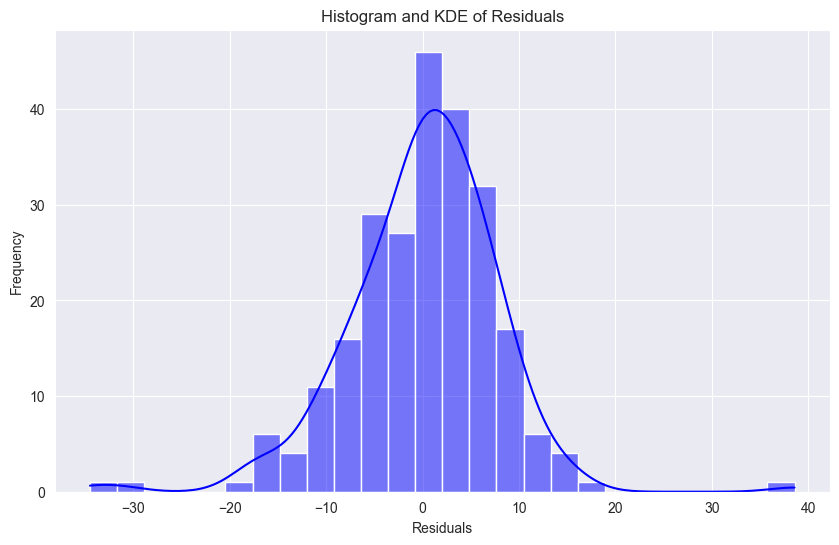

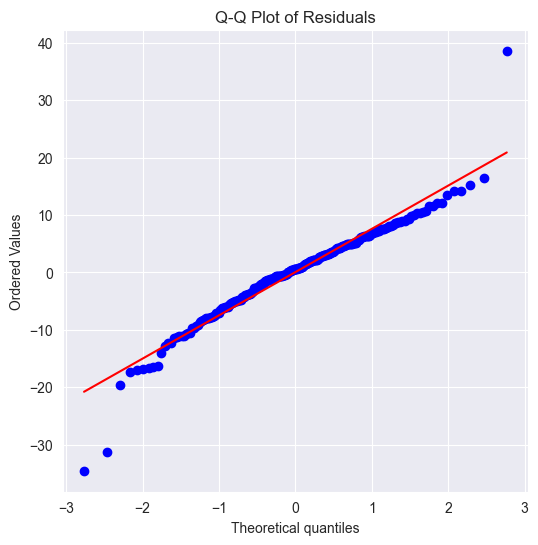

In [9]:
y_pred = model.predict(X_val)  # X_val_poly is your validation set with polynomial features
residuals = y_val - y_pred

print("Accuracy = ", r2_score(y_val, y_pred))

# Step 2: Plot the residuals using a histogram and KDE plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Histogram and KDE of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Step 3: Create a Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()